In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from copy import deepcopy as dc
from torch.utils.data import DataLoader
import torch
import tqdm

from helper_functions.model_builder import LSTM, VanillaDNN
from helper_functions.data_setup import TimeseriesDataset
from helper_functions.engine import train
from torchinfo import summary

import warnings
warnings.filterwarnings("ignore")

In [42]:
df = pd.read_csv("Datasets/Dataframes_one_ex_var/ModelBenchmark_dataframe.csv")
df.head(), df.shape

(                  Date  Price  FR Generation  FR Load
 0  2018-01-01 00:00:00   4.74        53625.0  56250.0
 1  2018-01-01 01:00:00   3.66        52398.0  54300.0
 2  2018-01-01 02:00:00   1.26        51825.0  53600.0
 3  2018-01-01 03:00:00 -20.10        50729.0  50000.0
 4  2018-01-01 04:00:00 -31.82        50719.0  47100.0,
 (43824, 4))

### Data Prep 
- Set Date as index
- Add dummies for weekdays
- Add lagged variables for price + exogenous variables

#### DATA LEAKAGE PROBLEM
#### How to do proper validation / test / train split

In [43]:
# Set Date as index
df.Date = pd.to_datetime(df.Date)
df.set_index("Date", inplace=True)

In [47]:
# add dummy variables for weekdays + 7 features
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for i, x in enumerate(names):
    df[x] = (df.index.get_level_values(0).weekday == i).astype(int)

# add lagged variables for price + exogenous variables + (92 + 72*N) features
def prepare_dataframe_laggs(df: pd.DataFrame, historical_price_laggs: list =  [1,2,3,7], historical_exo_laggs: list = [1,7]):
    df = dc(df)

    exo_var = df.columns[1:-7]

    laggs = []
    for i in historical_price_laggs:
        new_laggs = [x for x in list(range(i, 24*i)) if x not in list(range(i-1, 24*(i-1)))]
        laggs += new_laggs

    for i in laggs:
        df[f'Price(t-{i})'] = df["Price"].shift(i)

    laggs = []
    for i in historical_exo_laggs:
        new_laggs = [x for x in list(range(i, 24*i)) if x not in list(range(i-1, 24*(i-1)))]
        laggs += new_laggs

    for exo in exo_var:
        for j in laggs:
            df[f'{exo}(t-{j})'] = df[exo].shift(j)

    return df

lagged_df = prepare_dataframe_laggs(df, historical_price_laggs=[1,2,3,7], historical_exo_laggs=[1,7])
lagged_df.dropna(inplace=True)
lagged_df.head()

,Price,FR Generation,FR Load,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,...,FR Load(t-158),FR Load(t-159),FR Load(t-160),FR Load(t-161),FR Load(t-162),FR Load(t-163),FR Load(t-164),FR Load(t-165),FR Load(t-166),FR Load(t-167)
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-07 23:00:00,18.91,72256.0,63350.0,0,0,0,0,0,0,1,...,46950.0,46400.0,46000.0,45850.0,45850.0,47100.0,50000.0,53600.0,54300.0,56250.0
2018-01-08 00:00:00,15.15,71126.0,59650.0,1,0,0,0,0,0,0,...,49100.0,46950.0,46400.0,46000.0,45850.0,45850.0,47100.0,50000.0,53600.0,54300.0
2018-01-08 01:00:00,15.11,70217.0,57050.0,1,0,0,0,0,0,0,...,51500.0,49100.0,46950.0,46400.0,46000.0,45850.0,45850.0,47100.0,50000.0,53600.0
2018-01-08 02:00:00,13.42,70273.0,56200.0,1,0,0,0,0,0,0,...,54000.0,51500.0,49100.0,46950.0,46400.0,46000.0,45850.0,45850.0,47100.0,50000.0
2018-01-08 03:00:00,12.91,70608.0,53300.0,1,0,0,0,0,0,0,...,55100.0,54000.0,51500.0,49100.0,46950.0,46400.0,46000.0,45850.0,45850.0,47100.0


In [48]:
lagged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43657 entries, 2018-01-07 23:00:00 to 2022-12-31 23:00:00
Columns: 199 entries, Price to FR Load(t-167)
dtypes: float64(192), int32(7)
memory usage: 65.4 MB


In [5]:
import torch
import pandas as pd

# Assuming your DataFrame is named df
# Convert DataFrame to PyTorch tensors

# Extract features and target variable
features = lagged_df.drop(columns=['Price'])
target = lagged_df[['Price']]

# Convert to NumPy arrays
features_array = features.to_numpy()
target_array = target.to_numpy()

# Define sequence length and input size
sequence_length = 7  # Assuming you want to use 7 days of historical data (including lagged values)
input_size = features.shape[1]  # Number of features

# Convert to PyTorch tensors
features_tensor = torch.FloatTensor(features_array)
target_tensor = torch.FloatTensor(target_array)

# Define a function to create sequences with lagged values
def create_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(len(features) - sequence_length + 1):
        X.append(features[i:i+sequence_length, :])
        y.append(target[i+sequence_length-1:i+sequence_length, :])
    return torch.stack(X), torch.stack(y)

# Create sequences
X, y = create_sequences(features_tensor, target_tensor, sequence_length)

# Print the shapes of the tensors
print("Shape of input tensor (X):", X.shape)
print("Shape of target tensor (y):", y.shape)

Shape of input tensor (X): torch.Size([43650, 7, 17])
Shape of target tensor (y): torch.Size([43650, 1, 1])


In [6]:
features.shape[0]

43656

In [8]:
lagged_df_np = lagged_df.to_numpy()
lagged_df_np.shape

(43656, 18)

In [6]:
from sklearn.preprocessing import MinMaxScaler
# Transform features by scaling each feature to a given range. 
scaler = MinMaxScaler(feature_range=(-1,1))
lagged_df_np = scaler.fit_transform(lagged_df_np)
lagged_df_np

array([[-0.73545843,  0.35897357, -0.07413011, ..., -0.17821296,
        -0.01361573, -0.17700454],
       [-0.73553954,  0.33107216, -0.15279879, ..., -0.21587526,
        -0.11951589, -0.23600605],
       [-0.73896645,  0.33279106, -0.1785174 , ..., -0.23346327,
        -0.16792738, -0.25718608],
       ...,
       [-0.76133264, -0.45590718, -0.35249622, ..., -0.32680561,
        -0.27987897, -0.29803328],
       [-0.76591538, -0.43881028, -0.37670197, ..., -0.3605083 ,
        -0.26323752, -0.33282905],
       [-0.77508086, -0.52644341, -0.45839637, ..., -0.32708186,
        -0.33282905, -0.42057489]])

In [7]:
X = lagged_df_np[:, 1:]
y = lagged_df_np[:, 0]

# Test set = 2021/01/01 tot 2022/12/12
split_index = df.index.get_loc("2021-01-01 00:00:00")

X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26304, 17), (17352, 17), (26304,), (17352,))

In [8]:
X_train = X_train.reshape((-1, 17, 1))
X_test = X_test.reshape((-1, 17, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26304, 17, 1), (17352, 17, 1), (26304, 1), (17352, 1))

In [9]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([26304, 17, 1]),
 torch.Size([17352, 17, 1]),
 torch.Size([26304, 1]),
 torch.Size([17352, 1]))

In [10]:
train_dataset = TimeseriesDataset(X_train, y_train)
test_dataset = TimeseriesDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 17, 1]) torch.Size([16, 1])


In [13]:
"""
Contains PyTorch model code to instantiate a a series of different models.
"""
import torch
from torch import nn 
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VanillaDNN(nn.Module):
  """Creates a Vanilla Deep Neural Network architecture.

  Args:
    input_shape: An integer indicating number of input channels.
    hidden_units: An integer indicating number of hidden units between layers.
    output_shape: An integer indicating number of output units.
  """
  def __init__(self, input_shape: int, hidden_units1: int = 239, hidden_units2: int = 162, output_shape: int = 1) -> None:
      super().__init__()
      self.layer_stack = nn.Sequential(
       nn.Linear(in_features=input_shape, out_features=hidden_units1),
       nn.ReLU(),
       nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
       nn.ReLU(),
       nn.Linear(in_features=hidden_units2, out_features=hidden_units2)
      #  nn.Linear(in_features=hidden_units, out_features=1)
      )
      self.fc = nn.Linear(hidden_units2, 1)

  def forward(self, x: torch.Tensor):
      # x = x.view(x.size(0), -1)
      output = self.layer_stack(x)
      output = F.relu(output)
      output = self.fc(output[:, -1, :])
      # output = output.view(-1, 1)
      return output

In [14]:
model = VanillaDNN(1, 239, 162, 1)
model.to(device)
model

VanillaDNN(
  (layer_stack): Sequential(
    (0): Linear(in_features=1, out_features=239, bias=True)
    (1): ReLU()
    (2): Linear(in_features=239, out_features=162, bias=True)
    (3): ReLU()
    (4): Linear(in_features=162, out_features=162, bias=True)
  )
  (fc): Linear(in_features=162, out_features=1, bias=True)
)

In [15]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model, 
        input_size=(16, 17, 1), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VanillaDNN (VanillaDNN)                  [16, 17, 1]          [16, 1]              --                   True
├─Sequential (layer_stack)               [16, 17, 1]          [16, 17, 162]        --                   True
│    └─Linear (0)                        [16, 17, 1]          [16, 17, 239]        478                  True
│    └─ReLU (1)                          [16, 17, 239]        [16, 17, 239]        --                   --
│    └─Linear (2)                        [16, 17, 239]        [16, 17, 162]        38,880               True
│    └─ReLU (3)                          [16, 17, 162]        [16, 17, 162]        --                   --
│    └─Linear (4)                        [16, 17, 162]        [16, 17, 162]        26,406               True
├─Linear (fc)                            [16, 162]            [16, 1]              163                  True
Total params: 65,9

In [16]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from sklearn.metrics import mean_absolute_error as mae

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss

      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      # avg_loss_accross_batches = train_loss / 100
      train_acc += mae(y_pred.detach(), y)
      # y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      # train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch 
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval() 

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred, y.view(1, -1))
          test_loss += loss.item()          
          
          # Calculate and accumulate accuracy
          test_acc += mae(test_pred.detach(), y)
          # test_pred_labels = test_pred_logits.argmax(dim=1)
          # test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
  """Trains and tests a PyTorch model.

  Passes a target PyTorch models through train_step() and test_step()
  functions for a number of epochs, training and testing the model
  in the same epoch loop.

  Calculates, prints and stores evaluation metrics throughout.

  Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
  """
  # Create empty results dictionary
  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_MAE: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_MAE: {test_acc:.4f}"
      )

      # Update results dictionary
      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

  # Return the filled results at the end of the epochs
  return results

In [17]:
learning_rate = 0.01
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Start training with help from engine.py
train(model=model,
             train_dataloader=train_loader,
             test_dataloader=test_loader,
             loss_fn=loss_function,
             optimizer=optimizer,
             epochs=10,
             device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:07<01:11,  7.90s/it]

Epoch: 1 | train_loss: 0.0037 | train_MAE: 0.0365 | test_loss: 0.1583 | test_MAE: 0.3005


 20%|██        | 2/10 [00:16<01:05,  8.16s/it]

Epoch: 2 | train_loss: 0.0019 | train_MAE: 0.0307 | test_loss: 0.1470 | test_MAE: 0.2834


 30%|███       | 3/10 [00:24<00:58,  8.33s/it]

Epoch: 3 | train_loss: 0.0018 | train_MAE: 0.0297 | test_loss: 0.1422 | test_MAE: 0.2762


 40%|████      | 4/10 [00:33<00:50,  8.45s/it]

Epoch: 4 | train_loss: 0.0018 | train_MAE: 0.0297 | test_loss: 0.1469 | test_MAE: 0.2834


 50%|█████     | 5/10 [00:42<00:42,  8.55s/it]

Epoch: 5 | train_loss: 0.0017 | train_MAE: 0.0294 | test_loss: 0.1483 | test_MAE: 0.2854


 60%|██████    | 6/10 [00:50<00:34,  8.60s/it]

Epoch: 6 | train_loss: 0.0018 | train_MAE: 0.0296 | test_loss: 0.1474 | test_MAE: 0.2841


 70%|███████   | 7/10 [00:59<00:25,  8.58s/it]

Epoch: 7 | train_loss: 0.0018 | train_MAE: 0.0297 | test_loss: 0.1439 | test_MAE: 0.2787


 80%|████████  | 8/10 [01:07<00:17,  8.56s/it]

Epoch: 8 | train_loss: 0.0017 | train_MAE: 0.0293 | test_loss: 0.1461 | test_MAE: 0.2820


 90%|█████████ | 9/10 [01:16<00:08,  8.51s/it]

Epoch: 9 | train_loss: 0.0017 | train_MAE: 0.0293 | test_loss: 0.1432 | test_MAE: 0.2778


100%|██████████| 10/10 [01:24<00:00,  8.49s/it]

Epoch: 10 | train_loss: 0.0017 | train_MAE: 0.0294 | test_loss: 0.1495 | test_MAE: 0.2872


{'train_loss': [0.0037086356781660173,
  0.0018554267192677507,
  0.0017685544264827568,
  0.0017719641608008893,
  0.0017378994628497843,
  0.0017598698422618079,
  0.001773733275400366,
  0.0017328964027676277,
  0.0017382176057871067,
  0.0017437313160665873],
 'train_acc': [0.03645140840162108,
  0.030693150839231312,
  0.029740724374977486,
  0.029677670976994537,
  0.02936443169725891,
  0.02955563206660704,
  0.029680479247657775,
  0.02929568943316049,
  0.029311650886977604,
  0.029400500457579783],
 'test_loss': [0.15830843911426032,
  0.1469813251197094,
  0.1421867574188473,
  0.14692691638266392,
  0.14831787279689274,
  0.14739807579912953,
  0.1439150770198852,
  0.1460779525208435,
  0.14320311366360405,
  0.14948037613449083],
 'test_acc': [0.30050050477553075,
  0.28341838417033993,
  0.2762120073463785,
  0.2833722673287864,
  0.2854326920746933,
  0.2840537570966279,
  0.2786825421802734,
  0.2820052169023022,
  0.27781324508484057,
  0.2872470667525645]}

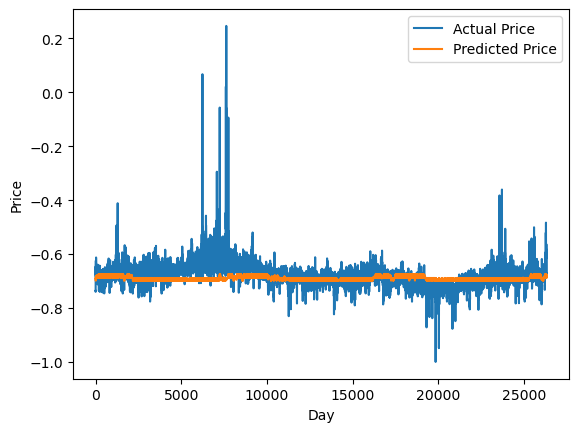

In [18]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label="Actual Price")
plt.plot(predicted, label='Predicted Price')
plt.xlabel("Day")
plt.ylabel("Price")

plt.legend()
plt.show()

In [72]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], 18))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:,0])
test_predictions

array([42.34221924, 42.32602296, 43.40744031, ..., 42.10062725,
       41.38957844, 39.596495  ])

In [75]:
dummies = np.zeros((X_test.shape[0], 18))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([43.90000108, 39.99999095, 39.99999095, ...,  2.3900063 ,
        0.12999396, -4.39000135])

In [83]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], 18))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([42.2449534 , 42.2449534 , 42.2449534 , ..., 47.74410319,
       47.74410319, 44.13647845])

In [84]:
dummies = np.zeros((X_train.shape[0], 18))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([15.14999616, 15.10999048, 13.41999295, ..., 53.05001465,
       45.1499949 , 46.58999366])

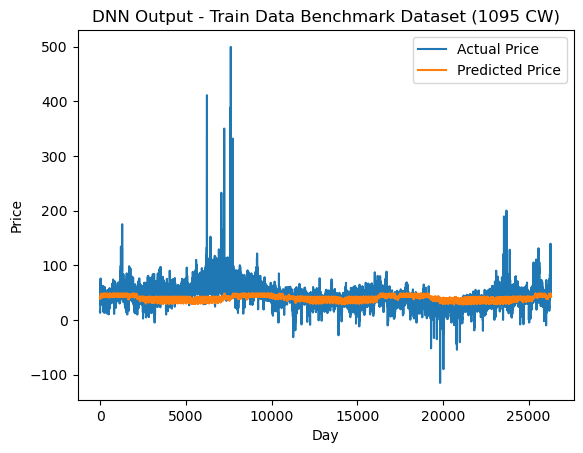

In [86]:
plt.plot(new_y_train, label="Actual Price")
plt.plot(train_predictions, label='Predicted Price')
plt.xlabel("Day")
plt.ylabel("Price")
plt.title("DNN Output - Train Data Benchmark Dataset (1095 CW)")
plt.legend()
plt.show()

In [76]:
mae(new_y_test, test_predictions)

139.43337320637565